In [1]:
!pip install pymongo pandas scikit-learn matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Goal: Predict transaction approval (success)  at the BIN-gateway-campaign level to optimize routing decisions.

#Identify BIN-gateway combinations that yield the highest success (approval) rates per campaign to optimize routing strategy.

In [2]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Your credentials
username = "soundDev"
password = "e1kemyOwhAYXNidM"
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"
database_name = "checkoutETL"
collection_name = "transactions"

# URL encode username and password in case of special chars
username = urllib.parse.quote_plus(username)
password = urllib.parse.quote_plus(password)

# Build the MongoDB connection string (note: mongodb:// not mongodb+srv://)
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/{database_name}"
    "?ssl=true&authSource=admin"
)

# Connect to MongoDB
client = MongoClient(mongo_uri)

# Select DB and collection
db = client[database_name]
collection = db[collection_name]

# Load data into DataFrame (limit to 1000 documents to avoid overload)
df = pd.DataFrame(list(collection.find()))

# Show first rows
print(df.head())


                        _id  transactionId 3DTxnResult  __v achBankName  \
0  6816c18f10f783ceceb640b1         438521       false    0        None   
1  6816c18f10f783ceceb640b9         438533       false    0        None   
2  6816c18f10f783ceceb640bb         438535       false    0        None   
3  6816c18f10f783ceceb640bc         438536       false    0        None   
4  6816c18f10f783ceceb640bd         438537       false    0        None   

   actualOrderId affId authCode avsResponse  billingCycleNumber  ...  \
0         292147  None     None        None                 3.0  ...   
1         292134  None     None        None                 1.0  ...   
2         292138  None     None        None                 1.0  ...   
3         292138  None     None        None                 1.0  ...   
4         292138  None     None        None                 1.0  ...   

  sourceValue2 sourceValue3 sourceValue4 sourceValue5  state  surcharge  \
0         None         None         None 

In [3]:
df.columns


Index(['_id', 'transactionId', '3DTxnResult', '__v', 'achBankName',
       'actualOrderId', 'affId', 'authCode', 'avsResponse',
       'billingCycleNumber', 'campaignCategoryName', 'campaignId',
       'campaignName', 'cardBin', 'cardIsDebit', 'cardIsPrepaid', 'cardLast4',
       'cardType', 'chargebackAmount', 'chargebackDate', 'chargebackNote',
       'chargebackReasonCode', 'city', 'clientOrderId', 'clientTxnId',
       'country', 'currencyCode', 'currencySymbol', 'custom1', 'custom2',
       'custom3', 'custom4', 'custom5', 'customerId', 'cvvResponse',
       'dateCreated', 'dateUpdated', 'funnelReferenceId', 'ipAddress',
       'isChargedback', 'items', 'merchant', 'merchantDescriptor',
       'merchantId', 'merchantTxnId', 'midNumber', 'orderAgentName', 'orderId',
       'orderType', 'parentTxnId', 'paySource', 'paySourceId', 'postalCode',
       'recycleNumber', 'refundReason', 'responseText', 'responseType',
       'sourceTitle', 'sourceValue1', 'sourceValue2', 'sourceValue3',


In [4]:
def map_response(x):
    if x == 'SUCCESS':
        return 1
    elif x in ['SOFT_DECLINE', 'HARD_DECLINE']:
        return 0
    else:
        return None  # for PENDING or other unexpected values

df['is_success'] = df['responseType'].apply(map_response)

# Drop rows where target is None (like PENDING)
df = df[df['is_success'].notna()]


In [5]:
grouped = df.groupby(['campaignName', 'cardBin', 'merchant']).agg(
    total_attempts=('transactionId', 'count'),
    total_successes=('is_success', 'sum')
).reset_index()

grouped['approval_rate'] = grouped['total_successes'] / grouped['total_attempts']

# Optionally filter groups with enough volume
grouped = grouped[grouped['total_attempts'] >= 40]

grouped['rank'] = grouped.groupby('campaignName')['approval_rate'].rank(method='first', ascending=False)

top_bins = grouped[grouped['rank'] <= 3].sort_values(['campaignName', 'rank'])



In [6]:
print(top_bins)



                               campaignName cardBin               merchant  \
748       BTE Hearing CIC Pro (Native) - UK  529930               Adyen US   
710       BTE Hearing CIC Pro (Native) - UK  492915               Adyen US   
771       BTE Hearing CIC Pro (Native) - UK  537410               Adyen US   
1124  BTE Hearing CIC Pro (Native) Original  414720  Finix Josh (Auth.net)   
3870                         MozzGuard - CA  518116         EMS Josh (NMI)   
3856                         MozzGuard - CA  516075         EMS Josh (NMI)   
3522                         MozzGuard - CA  450003      Payarc Josh (NMI)   
5557                               OptiFuel  410039         EMS Josh (NMI)   
7083                               OptiFuel  521333         EMS Josh (NMI)   
7408                               OptiFuel  542418      Payarc Josh (NMI)   
7931                          OptiFuel | AU  521729               ADYEN AU   
7924                          OptiFuel | AU  516361             

In [8]:
top_bins[['campaignName', 'merchant', 'cardBin', 'total_attempts', 'total_successes', 'approval_rate']]

,campaignName,merchant,cardBin,total_attempts,total_successes,approval_rate
748,BTE Hearing CIC Pro (Native) - UK,Adyen US,529930,47,42.0,0.893617
710,BTE Hearing CIC Pro (Native) - UK,Adyen US,492915,49,40.0,0.816327
771,BTE Hearing CIC Pro (Native) - UK,Adyen US,537410,60,27.0,0.450000
1124,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),414720,43,30.0,0.697674
3870,MozzGuard - CA,EMS Josh (NMI),518116,61,58.0,0.950820
3856,MozzGuard - CA,EMS Josh (NMI),516075,58,55.0,0.948276
3522,MozzGuard - CA,Payarc Josh (NMI),450003,57,54.0,0.947368
5557,OptiFuel,EMS Josh (NMI),410039,61,56.0,0.918033
7083,OptiFuel,EMS Josh (NMI),521333,48,44.0,0.916667
7408,OptiFuel,Payarc Josh (NMI),542418,53,48.0,0.905660


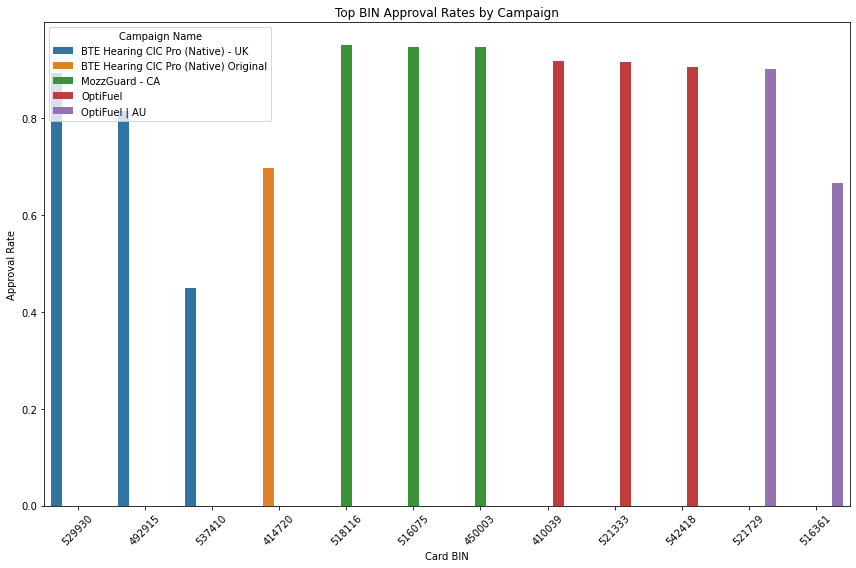

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose you have your grouped dataframe `top_bins` with these columns:
# 'campaignName', 'cardBin', 'merchant', 'approval_rate', 'total_attempts'

plt.figure(figsize=(12, 8))
sns.barplot(data=top_bins, x='cardBin', y='approval_rate', hue='campaignName')

plt.title('Top BIN Approval Rates by Campaign')
plt.xlabel('Card BIN')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.legend(title='Campaign Name')
plt.tight_layout()
plt.show()


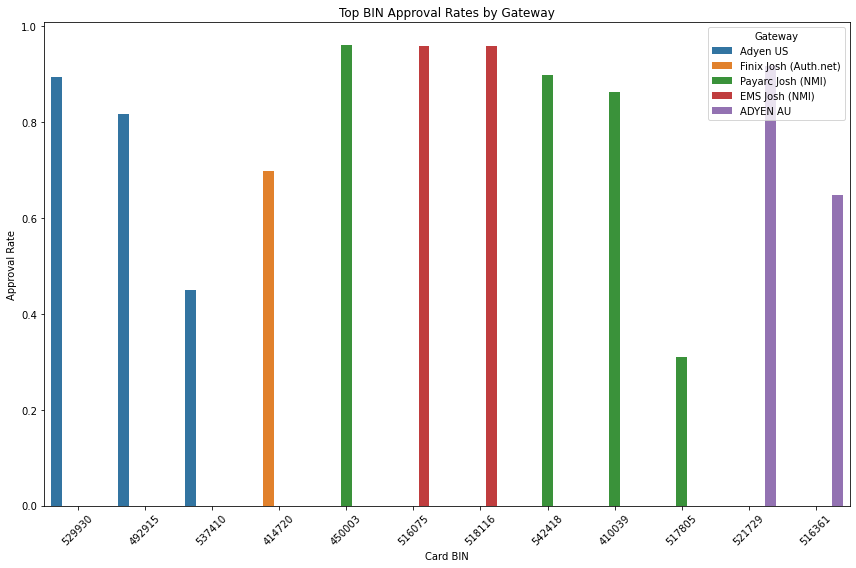

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose you have your grouped dataframe `top_bins` with these columns:
# 'campaignName', 'cardBin', 'merchant', 'approval_rate', 'total_attempts'

plt.figure(figsize=(12, 8))
sns.barplot(data=top_bins, x='cardBin', y='approval_rate', hue='merchant')

plt.title('Top BIN Approval Rates by Gateway')
plt.xlabel('Card BIN')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.legend(title='Gateway')
plt.tight_layout()
plt.show()



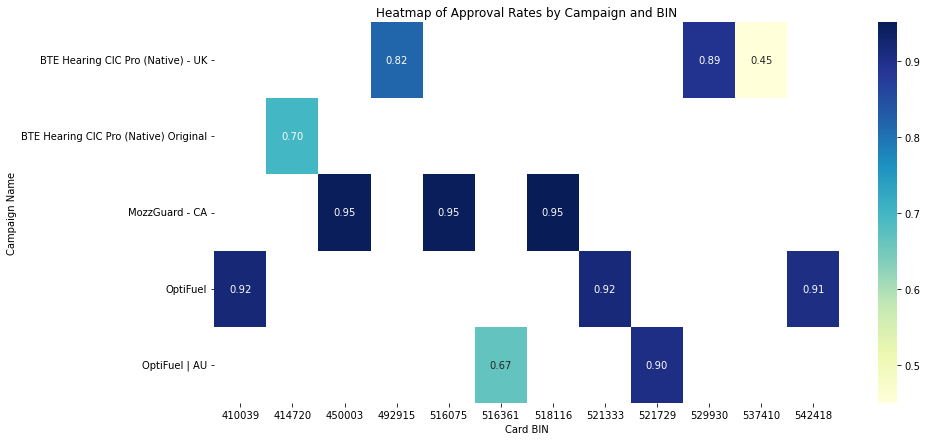

In [10]:
pivot_table = top_bins.pivot_table(index='campaignName', columns='cardBin', values='approval_rate')

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')

plt.title('Heatmap of Approval Rates by Campaign and BIN')
plt.xlabel('Card BIN')
plt.ylabel('Campaign Name')
plt.show()



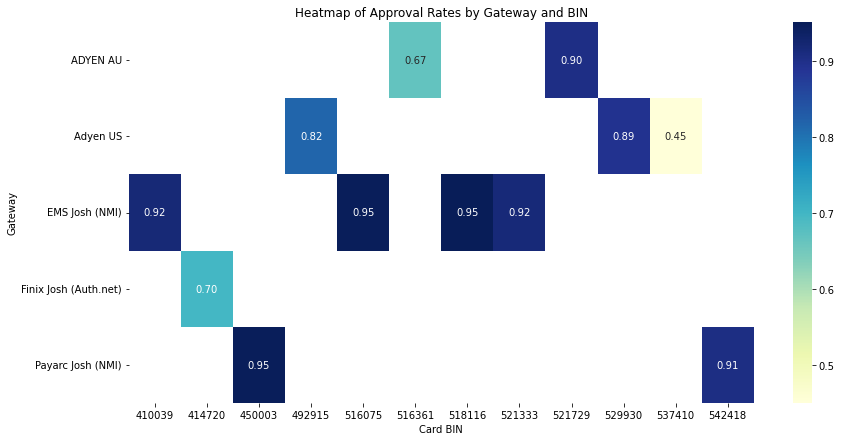

In [11]:
pivot_table = top_bins.pivot_table(index='merchant', columns='cardBin', values='approval_rate')

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')

plt.title('Heatmap of Approval Rates by Gateway and BIN')
plt.xlabel('Card BIN')
plt.ylabel('Gateway')
plt.show()


In [12]:
# Step 1: Create a success flag
df['is_success'] = df['responseType'].apply(lambda x: 1 if x == 'SUCCESS' else 0)



# Step 2: Group by campaign, gateway, and cardBin
grouped = df.groupby(['campaignName', 'merchant', 'cardBin']).agg(
    total_txns=('transactionId', 'count'),
    total_successes=('is_success', 'sum')
).reset_index()

# Step 4: Calculate approval rate
grouped['approval_rate'] = grouped['total_successes'] / grouped['total_txns']

# Step 5: Sort by approval rate and transaction volume to get the best overall performer
best_combo = grouped.sort_values(['approval_rate', 'total_txns'], ascending=[False, False]).head(10)

print(" Top-performing BIN-Gateway-Campaign combination:")
print(best_combo)


 Top-performing BIN-Gateway-Campaign combination:
                           campaignName           merchant cardBin  \
3490                     MozzGuard - CA           Adyen US  522303   
560   BTE Hearing CIC Pro (Native) - AU           ADYEN AU  521729   
3687                     MozzGuard - CA     EMS Josh (NMI)  522879   
6996                           OptiFuel  Payarc Josh (NMI)  552433   
3879                     MozzGuard - CA  Payarc Josh (NMI)  518116   
5224                     NeuroWrap - US      Phoenix (NMI)  000000   
5355                           OptiFuel           Adyen US  440066   
7431                           OptiFuel      Quantum (NMI)  542418   
3920                     MozzGuard - CA  Payarc Josh (NMI)  545756   
6107                           OptiFuel     EMS Josh (NMI)  542418   

      total_txns  total_successes  approval_rate  
3490          31               31            1.0  
560           24               24            1.0  
3687          23          

In [13]:
best_combo[['campaignName', 'merchant', 'cardBin', 'total_txns', 'total_successes', 'approval_rate']]

,campaignName,merchant,cardBin,total_txns,total_successes,approval_rate
3490,MozzGuard - CA,Adyen US,522303,31,31,1.0
560,BTE Hearing CIC Pro (Native) - AU,ADYEN AU,521729,24,24,1.0
3687,MozzGuard - CA,EMS Josh (NMI),522879,23,23,1.0
6996,OptiFuel,Payarc Josh (NMI),552433,23,23,1.0
3879,MozzGuard - CA,Payarc Josh (NMI),518116,22,22,1.0
5224,NeuroWrap - US,Phoenix (NMI),000000,22,22,1.0
5355,OptiFuel,Adyen US,440066,19,19,1.0
7431,OptiFuel,Quantum (NMI),542418,17,17,1.0
3920,MozzGuard - CA,Payarc Josh (NMI),545756,16,16,1.0
6107,OptiFuel,EMS Josh (NMI),542418,16,16,1.0


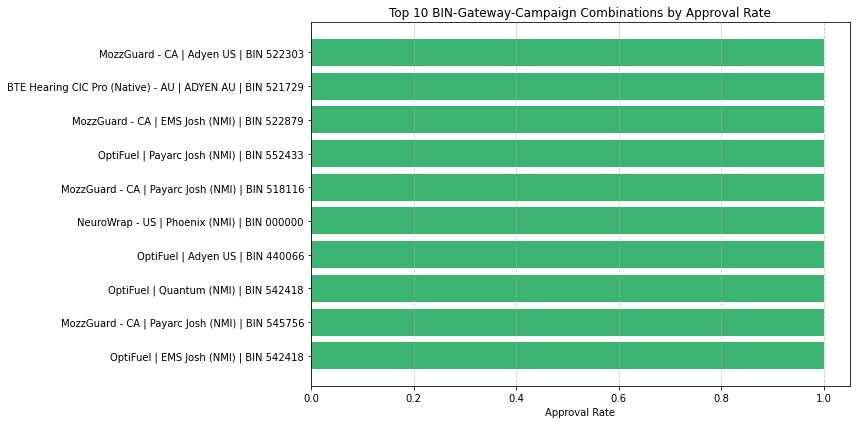

In [14]:
import matplotlib.pyplot as plt

# Step: Create a label for each row to show on y-axis
best_combo['label'] = (
    best_combo['campaignName'] + " | " +
    best_combo['merchant'] + " | BIN " +
    best_combo['cardBin'].astype(str)
)

# Step: Plotting
plt.figure(figsize=(12, 6))
plt.barh(best_combo['label'], best_combo['approval_rate'], color='mediumseagreen')
plt.xlabel('Approval Rate')
plt.title('Top 10 BIN-Gateway-Campaign Combinations by Approval Rate')
plt.gca().invert_yaxis()  # Highest approval rate on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [15]:
print(top_bins.columns.tolist())

['campaignName', 'cardBin', 'merchant', 'total_attempts', 'total_successes', 'approval_rate', 'rank']


In [16]:
#Bottom BIN-Gateway-Campaign Combos
# Step 1: Filter for combinations with enough volume
threshold = 50  # 
filtered_bottom = grouped[grouped['total_txns'] > threshold].copy()

# Step 2: Sort by approval_rate ascending (low to high)
bottom_combos = filtered_bottom.sort_values(['approval_rate', 'total_txns'], ascending=[True, False]).head(10)

# Step 3: Create label for visualization
bottom_combos['label'] = (
    bottom_combos['campaignName'] + " | " +
    bottom_combos['merchant'] + " | BIN " +
    bottom_combos['cardBin'].astype(str)
)

# Step 4: Display the worst combinations
print("🔻 Bottom-performing BIN-Gateway-Campaign combinations (txn count > 30):")
print(bottom_combos[['campaignName', 'merchant', 'cardBin', 'total_txns', 'total_successes', 'approval_rate']])


🔻 Bottom-performing BIN-Gateway-Campaign combinations (txn count > 30):
                           campaignName           merchant cardBin  \
749   BTE Hearing CIC Pro (Native) - UK           Adyen US  535666   
3621                     MozzGuard - CA     EMS Josh (NMI)  452088   
6810                           OptiFuel  Payarc Josh (NMI)  517805   
760   BTE Hearing CIC Pro (Native) - UK           Adyen US  537410   
3680                     MozzGuard - CA     EMS Josh (NMI)  519123   
7920                      OptiFuel | AU           ADYEN AU  516361   
3602                     MozzGuard - CA     EMS Josh (NMI)  451401   
3741                     MozzGuard - CA     EMS Josh (NMI)  552490   
3815                     MozzGuard - CA  Payarc Josh (NMI)  451401   
3581                     MozzGuard - CA     EMS Josh (NMI)  450003   

      total_txns  total_successes  approval_rate  
749           51                4       0.078431  
3621          56                8       0.142857  
6810

In [17]:
bottom_combos[['campaignName', 'merchant', 'cardBin', 'total_txns', 'total_successes', 'approval_rate']]


,campaignName,merchant,cardBin,total_txns,total_successes,approval_rate
749,BTE Hearing CIC Pro (Native) - UK,Adyen US,535666,51,4,0.078431
3621,MozzGuard - CA,EMS Josh (NMI),452088,56,8,0.142857
6810,OptiFuel,Payarc Josh (NMI),517805,52,19,0.365385
760,BTE Hearing CIC Pro (Native) - UK,Adyen US,537410,60,27,0.450000
3680,MozzGuard - CA,EMS Josh (NMI),519123,94,48,0.510638
7920,OptiFuel | AU,ADYEN AU,516361,63,42,0.666667
3602,MozzGuard - CA,EMS Josh (NMI),451401,122,89,0.729508
3741,MozzGuard - CA,EMS Josh (NMI),552490,54,41,0.759259
3815,MozzGuard - CA,Payarc Josh (NMI),451401,65,50,0.769231
3581,MozzGuard - CA,EMS Josh (NMI),450003,86,70,0.813953


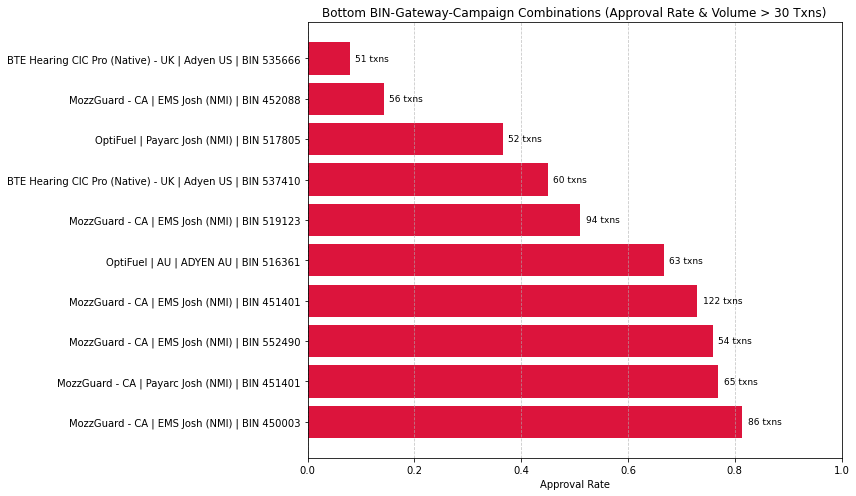

In [18]:
import matplotlib.pyplot as plt

# Filter combinations with transaction count > 50
threshold = 50
filtered_bottom = grouped[grouped['total_txns'] > threshold].copy()

# Sort by approval_rate ascending (lowest first) and take top 10 worst performers
bottom_combos = filtered_bottom.sort_values(['approval_rate', 'total_txns'], ascending=[True, False]).head(10)

# Create label for plotting
bottom_combos['label'] = (
    bottom_combos['campaignName'] + " | " +
    bottom_combos['merchant'] + " | BIN " +
    bottom_combos['cardBin'].astype(str)
)

# Plotting
plt.figure(figsize=(12, 7))
bars = plt.barh(bottom_combos['label'], bottom_combos['approval_rate'], color='crimson')

# Annotate transaction counts on the right of bars
for bar, txn in zip(bars, bottom_combos['total_txns']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{txn} txns", va='center', fontsize=9)

plt.xlabel('Approval Rate')
plt.title('Bottom BIN-Gateway-Campaign Combinations (Approval Rate & Volume > 30 Txns)')
plt.xlim(0, 1)
plt.gca().invert_yaxis()  # highest bar at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1]:
# bin and campaign consatnt and we want to see which merchant is performing best under these constants.
#bin and gateway constant and which campaign performs best.